In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.ticker as mticker
from torchdiffeq import odeint
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']
)

swap_rates = data.iloc[:, -8:] 
currencies = data["Currency"]  
dates = data["Date"] 

train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  
    currency_dates = dates[currencies == currency]  
    currency_labels = currencies[currencies == currency]  

    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=3, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        
        self.encoder = nn.Linear(8, latent_dim, bias=False)

        self.H_hidden = nn.Linear(latent_dim, latent_dim, bias=False) 
        self.H_activation = CenteredSoftmax()  
        self.H_output = nn.Linear(latent_dim, latent_dim, bias=False)  

        self.G_hidden = nn.Linear(latent_dim, latent_dim + 3, bias=False) 
        self.G_activation = CenteredSoftmax() 
        self.G_output = nn.Linear(latent_dim + 3, latent_dim + 3, bias=False) 

        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax() 
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]

        z = self.encoder(x)

        z_repeated = z.unsqueeze(1).repeat(1, 31, 1)
        z_repeated.requires_grad_(True)

        maturities = torch.linspace(0, 30, steps=31, dtype=torch.float32, device=x.device).unsqueeze(0).expand(batch_size, -1)
        maturities = maturities.clone().detach().requires_grad_(True)

        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)

        hidden = self.activation(self.decoder_hidden(decoder_input))
        zero_coupon_rates = self.decoder_output(hidden).squeeze(-1)

        H_hidden_out = self.H_activation(self.H_hidden(z_repeated)) 
        mu = self.H_output(H_hidden_out)  

        G_hidden_out = self.G_activation(self.G_hidden(z_repeated)) 
        G_out = self.G_output(G_hidden_out)

        sigma1 = torch.exp(G_out[:, :, 0])
        sigma2 = torch.exp(G_out[:, :, 1])
        sigma3 = torch.exp(G_out[:, :, 2])
        rho12 = torch.tanh(G_out[:, :, 3])
        rho13 = torch.tanh(G_out[:, :, 4])
        rho23 = torch.tanh(G_out[:, :, 5])

        sigma_matrix = torch.zeros(batch_size, 31, 3, 3, device=x.device) 
        sigma_matrix[:, :, 0, 0] = sigma1
        sigma_matrix[:, :, 1, 0] = rho12 * sigma2
        sigma_matrix[:, :, 1, 1] = torch.sqrt(1 - rho12 ** 2) * sigma2
        sigma_matrix[:, :, 2, 0] = rho13 * sigma3
        sigma_matrix[:, :, 2, 1] = (
            rho23 - rho12 * rho13
        ) / (torch.sqrt(1 - rho12 ** 2)) * sigma3
        sigma_matrix[:, :, 2, 2] = torch.sqrt(
            torch.clamp(
                1 - rho13 ** 2 - ((rho23 - rho12 * rho13) / (torch.sqrt(1 - rho12 ** 2) + 1e-6)) ** 2,
                min=1e-6)) * sigma3

        risk_neutral_rate = zero_coupon_rates[:, 0].unsqueeze(1).repeat(1, 31)

        discount_factors = torch.exp(-zero_coupon_rates * maturities)

        gradients_maturities = torch.autograd.grad(
            outputs=discount_factors,
            inputs=maturities,
            grad_outputs=torch.ones_like(discount_factors),
            create_graph=True
        )[0]

        gradients_latent = torch.autograd.grad(
            outputs=discount_factors, 
            inputs=z_repeated,        
            grad_outputs=torch.ones_like(discount_factors),  
            create_graph=True 
        )[0]

        hessian_list = []
        for i in range(latent_dim):  
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,  
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1)) 

        hessian = torch.cat(hessian_list, dim=-1)

        return zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors

# Convert zero-coupon rates to swap rates
def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    zero_coupon_rates = zero_coupon_rates[:, 1:] 
    maturities = torch.arange(1, 31, dtype=torch.float32, device=zero_coupon_rates.device).unsqueeze(0)

    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums

    return swap_rates

def finance_informed_loss(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):

    term_1 = -r_t * discount_factors 

    term_2 = gradients_maturities  

    term_3 = torch.sum(gradients_latent * mu, dim=2)

    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),                
        torch.matmul(hessian, sigma_matrix)            
    )
    trace_sigma_H_sigma = (
        sigma_H_sigma[..., 0, 0] +
        sigma_H_sigma[..., 1, 1] +
        sigma_H_sigma[..., 2, 2]
    )  

    term_4 = 0.5 * trace_sigma_H_sigma  

    terms = term_1 - term_2 + term_3 + term_4 

    arbitrage_loss = torch.mean(terms ** 2)

    return arbitrage_loss, terms

# Set fixed parameters
initial_learning_rate = 0.01 
batch_size = 32
latent_dim = 3
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50) 
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []
train_arbitrage = []
val_arbitrage = []

best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_train = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss = mse_train + arbitrage_loss
        loss.backward()
        optimizer.step()
        total_train_loss += mse_train.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5 
    train_losses.append(avg_train_loss)
    avg_train_arbitrage = torch.mean(abs(terms))
    train_arbitrage.append(avg_train_arbitrage)
    
    # Validation
    model.eval()
    total_val_loss = 0
    for X_batch in val_loader:
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_val = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        val_loss = mse_val + arbitrage_loss
        total_val_loss += mse_val.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5
    val_losses.append(avg_val_loss)
    avg_val_arbitrage = torch.mean(abs(terms))
    val_arbitrage.append(avg_val_arbitrage)
    
    # Update learning rate scheduler
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

model.load_state_dict(best_model_state) 
torch.save(best_model_state, "best_fiae3_model.pt") 

Epoch 0, Train RMSE: 0.017862, Val RMSE: 0.011585, LR: 0.010000
Epoch 100, Train RMSE: 0.002107, Val RMSE: 0.001725, LR: 0.008100
Epoch 200, Train RMSE: 0.001057, Val RMSE: 0.001134, LR: 0.006561
Epoch 300, Train RMSE: 0.001073, Val RMSE: 0.000847, LR: 0.005314
Epoch 400, Train RMSE: 0.000910, Val RMSE: 0.000813, LR: 0.004305
Epoch 500, Train RMSE: 0.001223, Val RMSE: 0.000835, LR: 0.003487
Epoch 600, Train RMSE: 0.000871, Val RMSE: 0.000782, LR: 0.002824
Epoch 700, Train RMSE: 0.000872, Val RMSE: 0.000715, LR: 0.002288
Epoch 800, Train RMSE: 0.000746, Val RMSE: 0.000660, LR: 0.001853
Epoch 900, Train RMSE: 0.000676, Val RMSE: 0.000606, LR: 0.001501
Epoch 1000, Train RMSE: 0.000644, Val RMSE: 0.000567, LR: 0.001216
Epoch 1100, Train RMSE: 0.000619, Val RMSE: 0.000548, LR: 0.000985
Epoch 1200, Train RMSE: 0.000601, Val RMSE: 0.000530, LR: 0.000798
Epoch 1300, Train RMSE: 0.000588, Val RMSE: 0.000520, LR: 0.000646
Epoch 1400, Train RMSE: 0.000587, Val RMSE: 0.000514, LR: 0.000523
Epoch 1

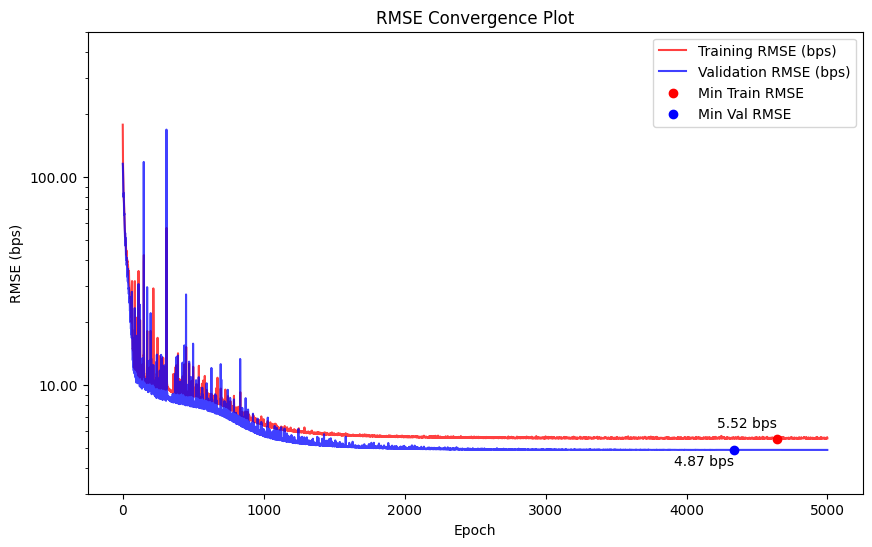

In [ ]:
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 0.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 0.9, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')  
plt.ylim(3, 500)
plt.yticks([10, 100])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.legend()
plt.show()

In [ ]:
#model.load_state_dict(torch.load("best_fiae2_model.pt"))

model.eval()

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

def finance_informed_loss_abs(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):
    term_1 = -r_t * discount_factors 

    term_2 = gradients_maturities  

    term_3 = torch.sum(gradients_latent * mu, dim=2) 

    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),               
        torch.matmul(hessian, sigma_matrix)             
    )
    trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1] + sigma_H_sigma[..., 2, 2] 

    term_4 = 0.5 * trace_sigma_H_sigma 

    arbitrage_loss = torch.mean(torch.abs(term_1 - term_2 + term_3 + term_4))

    return arbitrage_loss

def compute_metrics(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)

    mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
    rmse = mse_loss.sqrt().item() * 10_000  

    arbitrage_loss = finance_informed_loss_abs(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
    abs_arbitrage = arbitrage_loss.item() * 10_000 

    return rmse, abs_arbitrage

currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_arbitrage = compute_metrics(model, currency_train_tensor)
    val_rmse, val_arbitrage = compute_metrics(model, currency_val_tensor)
    test_rmse, test_arbitrage = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse,
        "Train Absolute Arbitrage Loss": train_arbitrage,
        "Validation Absolute Arbitrage Loss": val_arbitrage,
        "Test Absolute Arbitrage Loss": test_arbitrage
    })

rmse_df = pd.DataFrame(currency_metrics)

# Add average row
average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()
average_train_arbitrage_loss = rmse_df["Train Absolute Arbitrage Loss"].mean()
average_val_arbitrage_loss = rmse_df["Validation Absolute Arbitrage Loss"].mean()

rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Train Absolute Arbitrage Loss"].mean(),
    rmse_df["Validation Absolute Arbitrage Loss"].mean(),
    rmse_df["Test Absolute Arbitrage Loss"].mean()
]

# Print DataFrame
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)  Train Absolute Arbitrage Loss  Validation Absolute Arbitrage Loss  Test Absolute Arbitrage Loss
     AUD          6.264013               4.483451         8.845693                       2.015959                            1.610968                      2.298266
     CAD          5.857475               6.271492        13.370833                       2.089981                            1.890388                      5.941499
     DKK          5.402513               3.027570        10.857270                       2.055941                            1.914114                      4.114485
     EUR          5.317500               4.452730        11.930459                       2.124178                            2.214914                      4.675731
     GBP          4.765309               4.884559              NaN                       2.542295                            2.898675                           NaN
     JPY        

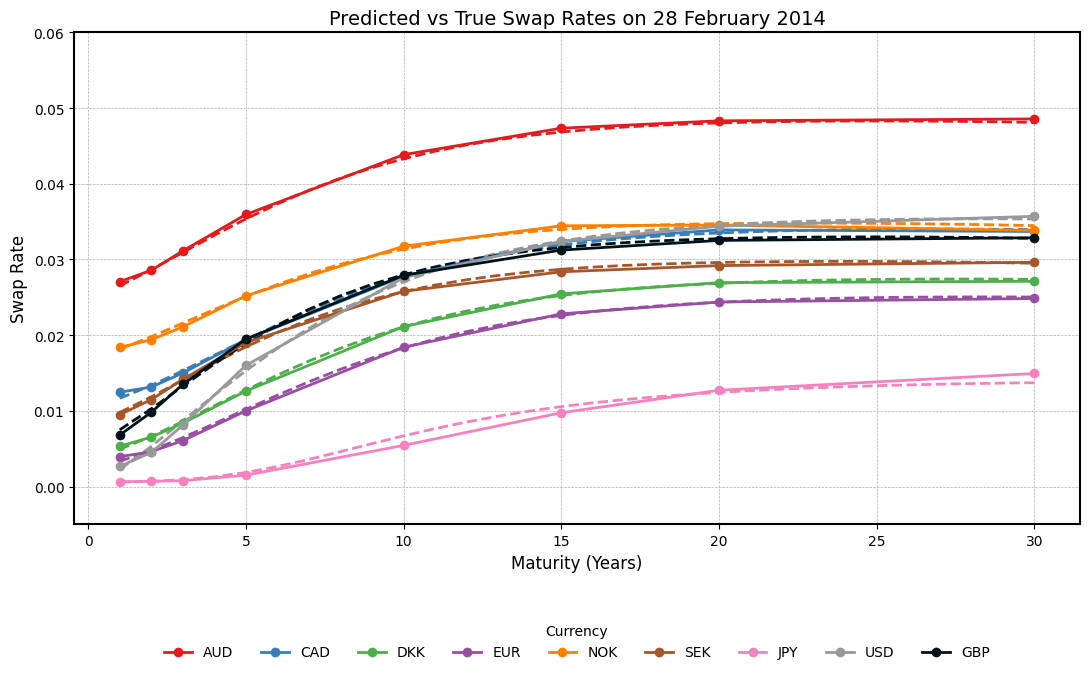

In [ ]:
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(selected_data)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

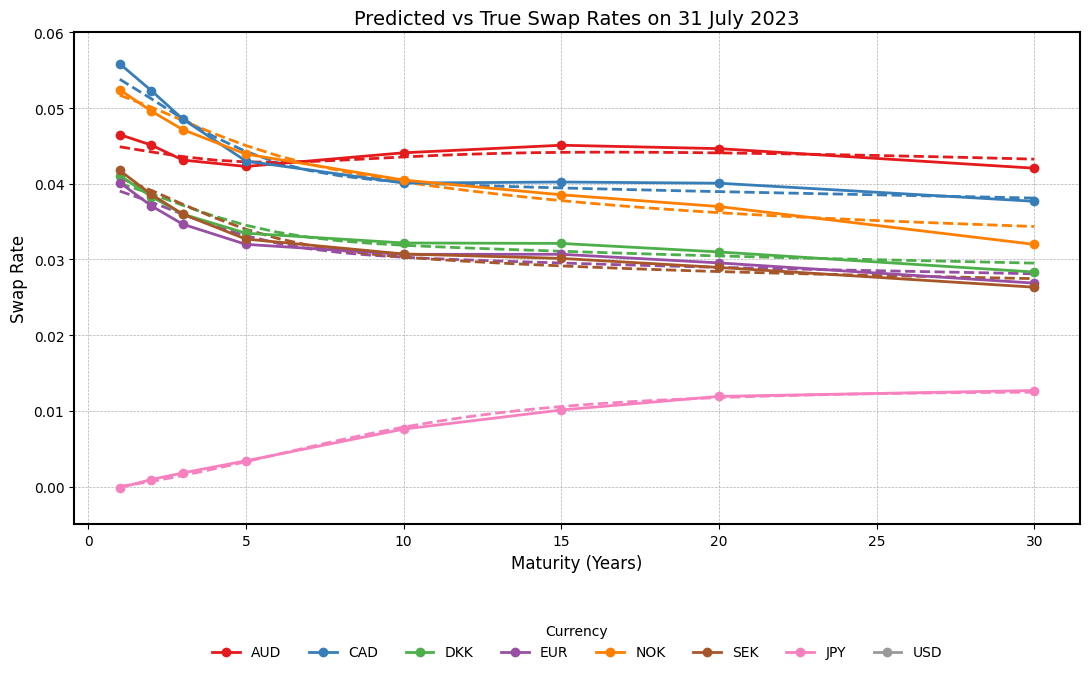

In [ ]:
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(filtered_data_tensor)
predicted_swaps = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)  

plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)               

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [ ]:
data_tensor = torch.cat((train_tensor, val_tensor), dim=0)
data_currencies_np = np.concatenate((train_currencies_np, val_currencies_np))

def leave_one_currency_out_cv(model, data_tensor, data_currencies_np):
    unique_currencies = np.unique(data_currencies_np)
    results = []
    
    for left_out_currency in unique_currencies:
        print(f"Leaving out: {left_out_currency}")
        
        train_mask = data_currencies_np != left_out_currency
        test_mask = data_currencies_np == left_out_currency
        
        train_data = data_tensor[train_mask]
        test_data = data_tensor[test_mask]
        
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 50))
        criterion = torch.nn.MSELoss()
        
        for epoch in range(5000):
            zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(train_data)
            swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)
            loss = criterion(swap_rates_pred[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        model.eval()
        zero_coupon_rates_pred_test, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(test_data)
        swap_rates_pred_test = zero_coupon_to_swap_rates(zero_coupon_rates_pred_test, maturities)
        rmse_unseen = torch.sqrt(criterion(swap_rates_pred_test[:, [0, 1, 2, 4, 9, 14, 19, 29]], test_data)).item() * 10_000
        
        zero_coupon_rates_pred_train, _, maturities = model(train_data)
        swap_rates_pred_train = zero_coupon_to_swap_rates(zero_coupon_rates_pred_train, maturities)
        rmse_seen = torch.sqrt(criterion(swap_rates_pred_train[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)).item() * 10_000 
    
        results.append({"Currency Left Out": left_out_currency, "RMSE Unseen (bps)": rmse_unseen, "RMSE Seen (bps)": rmse_seen})
    
    return results

cv_results = leave_one_currency_out_cv(model, data_tensor, data_currencies_np)

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))

In [ ]:
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
    swap_rates_selected = swap_rates[:, selected_indices]

    mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
    rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000  
    return rmse_per_maturity.cpu().detach().numpy()

rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

,Maturity (Years),Train RMSE (bps),Validation RMSE (bps),Test RMSE (bps)
0,1,8.155128,6.668504,18.329103
1,2,4.575147,3.642566,7.821221
2,3,6.157531,5.333372,12.562550
3,5,4.370967,4.160367,9.128210
4,10,5.196249,4.964296,7.067400
5,15,4.549448,4.226829,10.310323
6,20,2.921904,2.564682,6.630242
7,30,6.777183,6.077825,12.641242


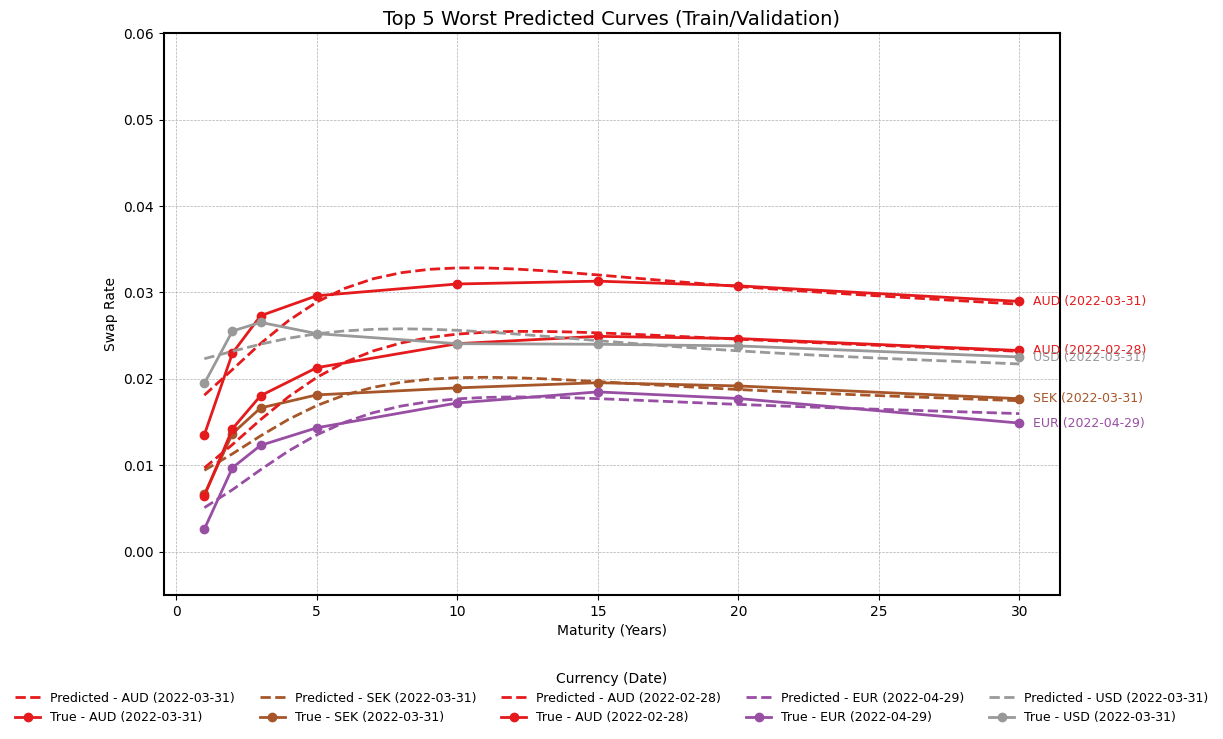

In [ ]:
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(train_val_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    plt.text(
        x=selected_maturities[-1] + 0.5,
        y=true_curve[-1],
        s=label,
        fontsize=9,
        color=color,
        verticalalignment='center'
    )

plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25) 
plt.show()

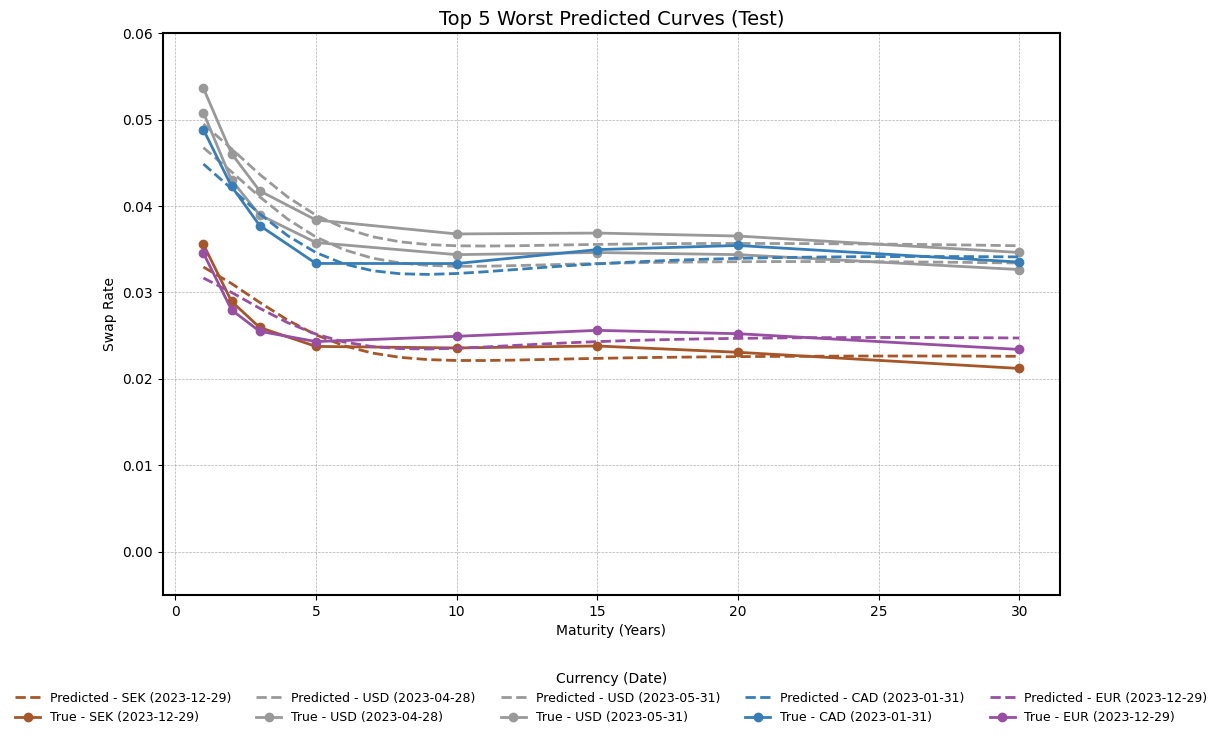

In [ ]:
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(test_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

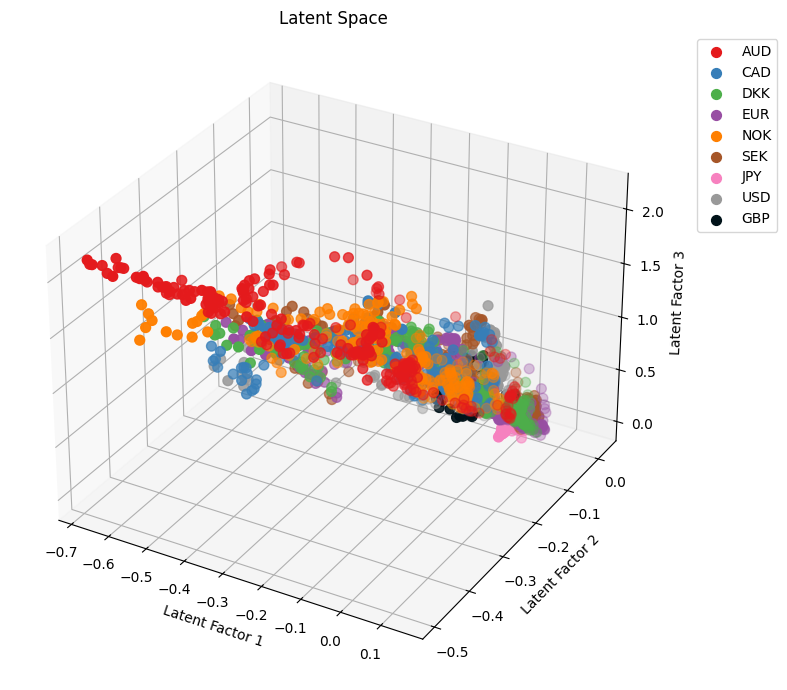

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

# model.load_state_dict(torch.load("best_fiae3_model.pt"))
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Latent_3": z[:, 2].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for currency in legend_order:
    subset = latent_df[latent_df["Currency"] == currency]
    ax.scatter(
        subset["Latent_1"],
        subset["Latent_2"],
        subset["Latent_3"],
        label=currency,
        color=custom_palette.get(currency, "#000000"),
        s=50
    )

ax.set_title("Latent Space")
ax.set_xlabel("Latent Factor 1")
ax.set_ylabel("Latent Factor 2")
ax.set_zlabel("Latent Factor 3")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

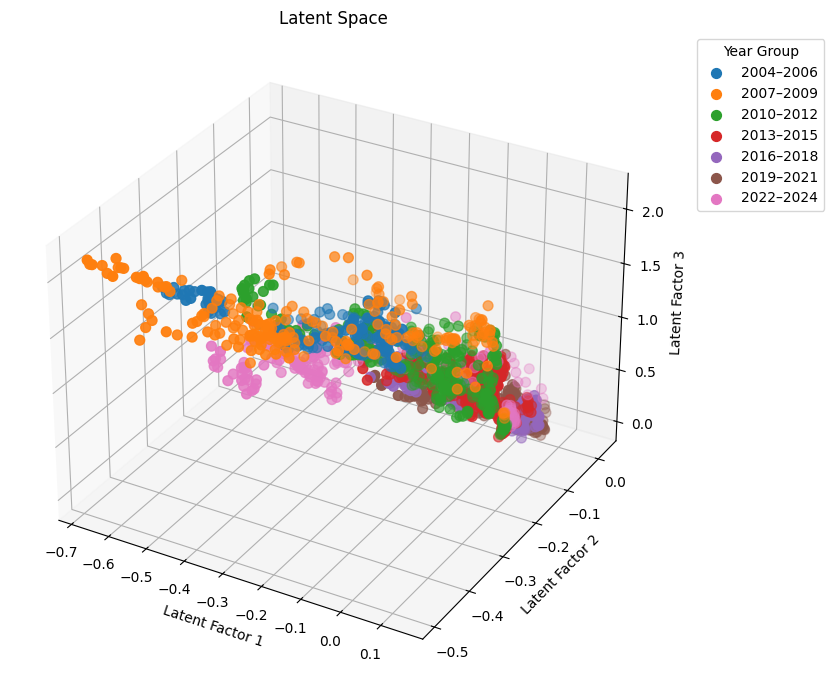

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
year_groups = data_filtered["YearGroup"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)

latent_dim = z.shape[1]
latent_df = pd.DataFrame(z.detach().numpy(), columns=[f"Latent_{i+1}" for i in range(latent_dim)])
latent_df["YearGroup"] = year_groups

year_group_order = sorted(latent_df["YearGroup"].unique())
palette = sns.color_palette("tab10", n_colors=len(year_group_order))
year_palette = {grp: col for grp, col in zip(year_group_order, palette)}

if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=latent_df, x="Latent_1", y="Latent_2",
        hue="YearGroup", palette=year_palette, hue_order=year_group_order, s=70
    )
    plt.title("Latent Space Grouped by 3-Year Periods (2D)")
    plt.xlabel("Latent Factor 1")
    plt.ylabel("Latent Factor 2")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

elif latent_dim == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(elev=30, azim=45)
    for group in year_group_order:
        subset = latent_df[latent_df["YearGroup"] == group]
        ax.scatter(
            subset["Latent_1"], subset["Latent_2"], subset["Latent_3"],
            label=group, color=year_palette[group], s=50
        )
    ax.set_title("Latent Space")
    ax.set_xlabel("Latent Factor 1")
    ax.set_ylabel("Latent Factor 2")
    ax.set_zlabel("Latent Factor 3")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

else:
    print(f"Latent dimension {latent_dim} not supported for plotting.")

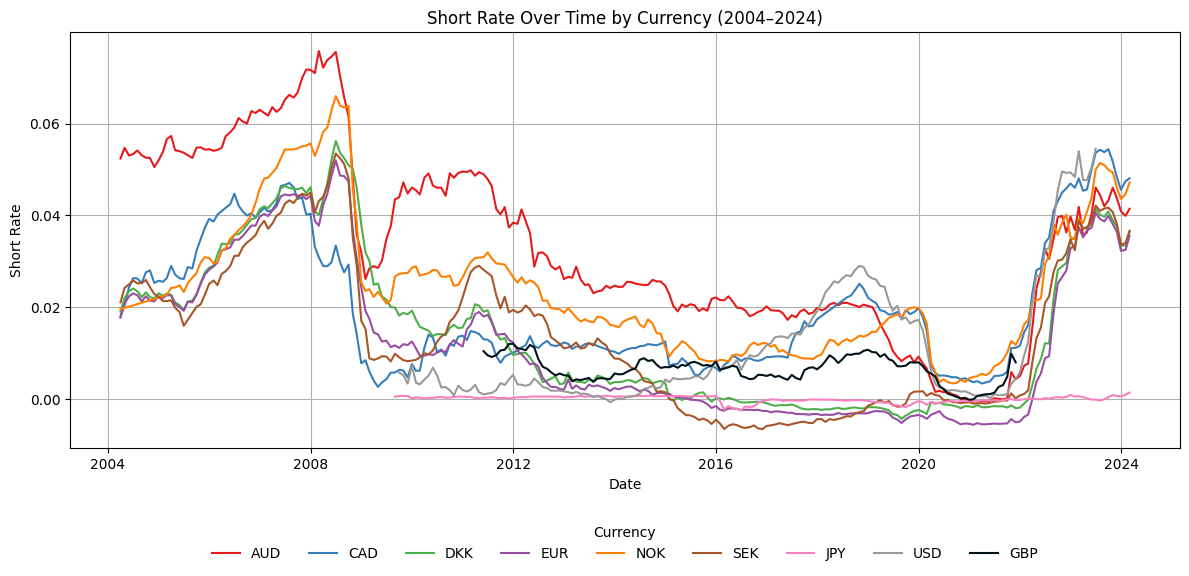

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

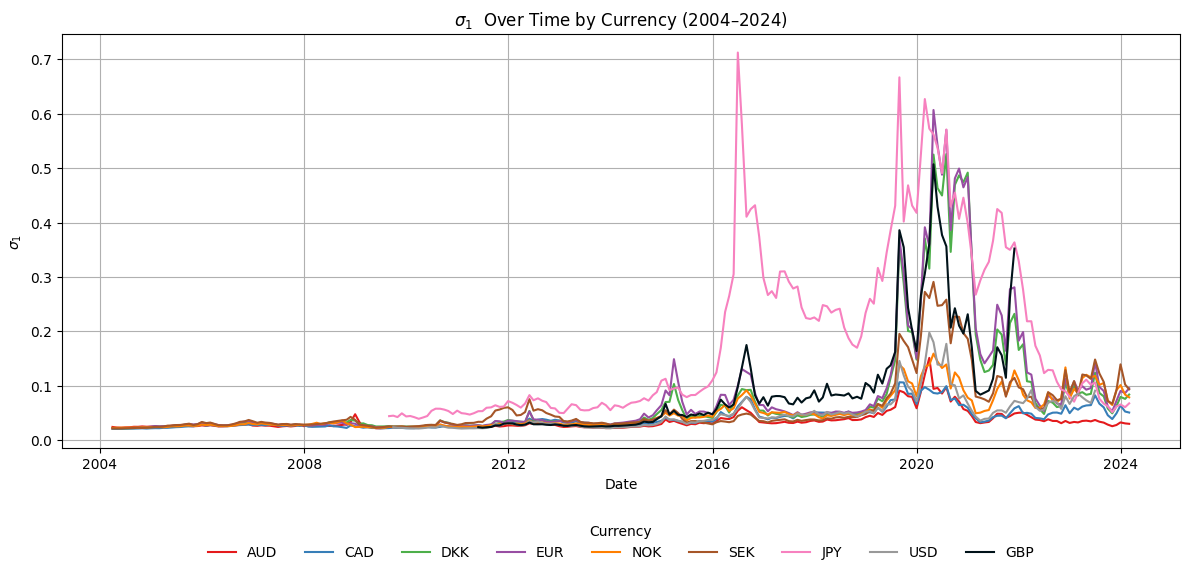

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

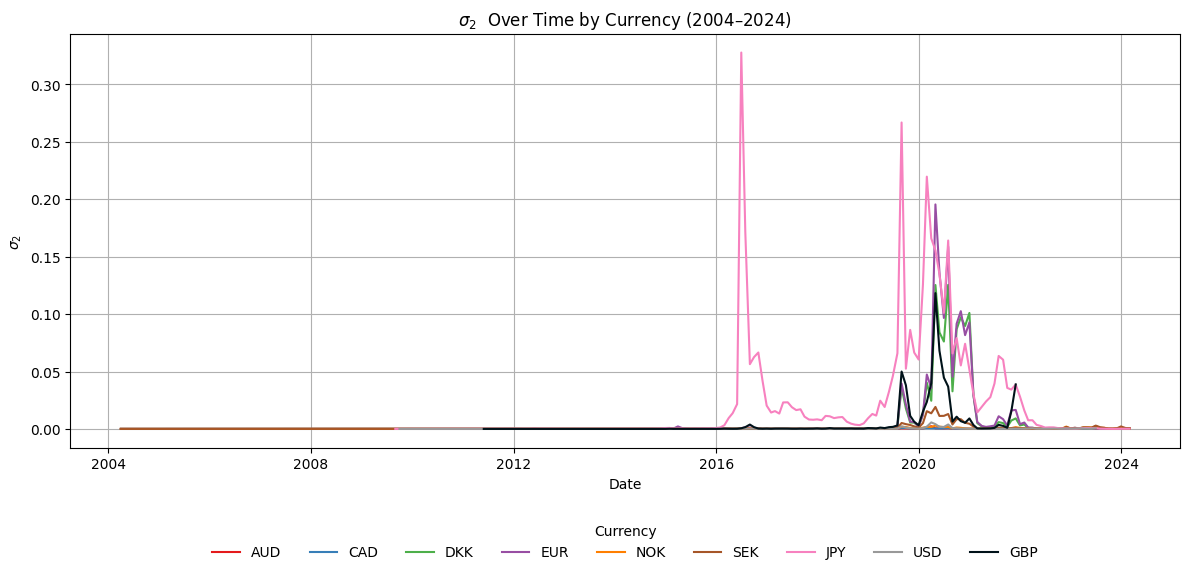

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

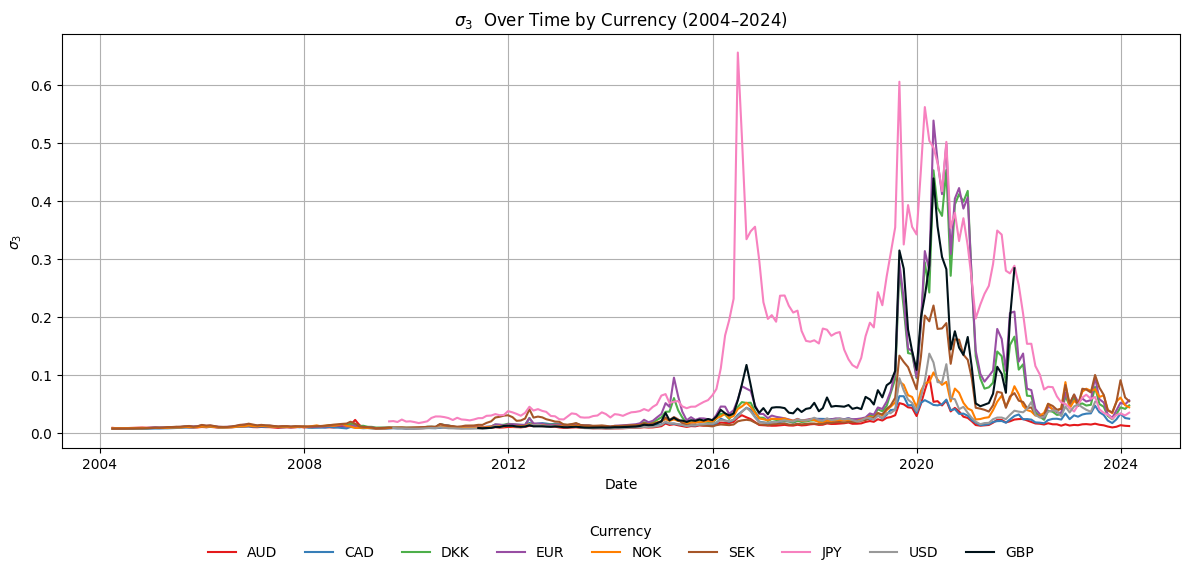

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma2_at_short_maturity = sigma3[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_3$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

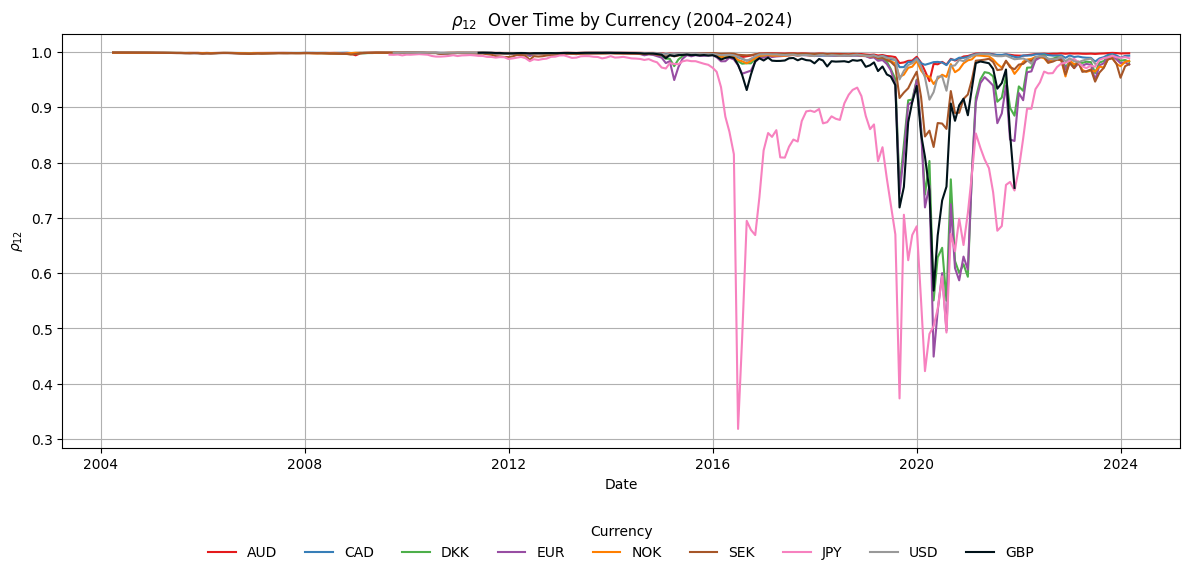

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho12[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{12}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{12}$")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

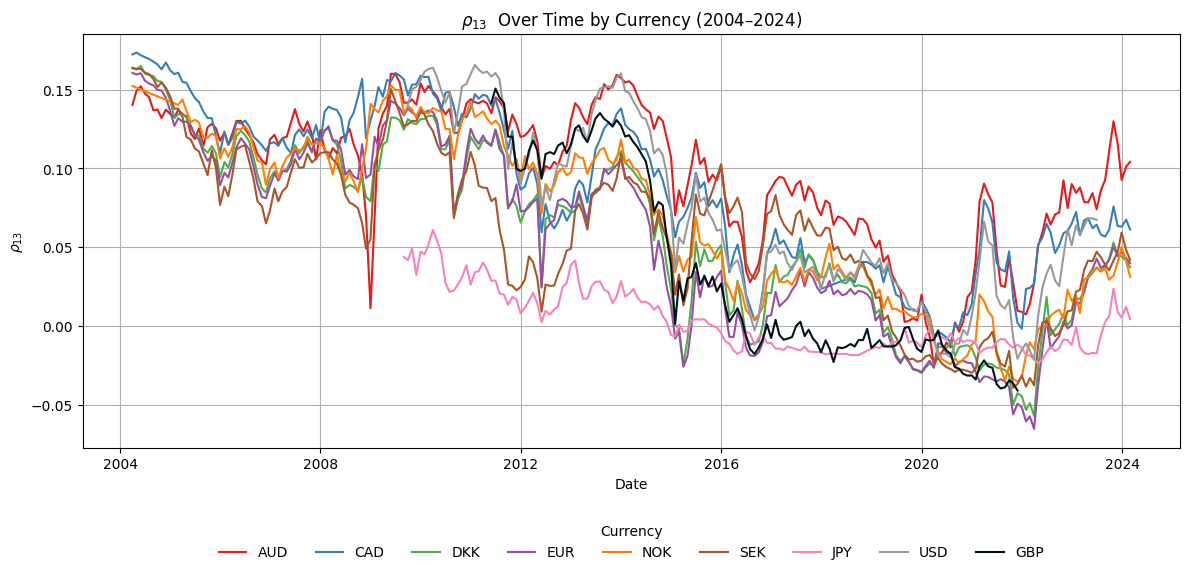

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho13[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{13}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{13}$")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

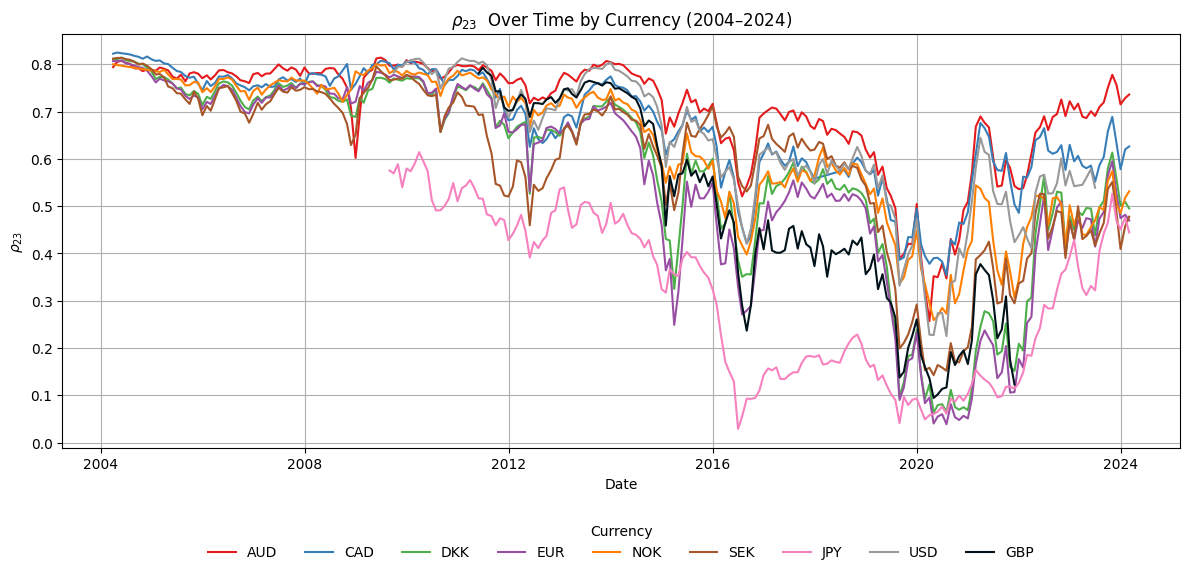

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho23[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{23}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{23}$")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

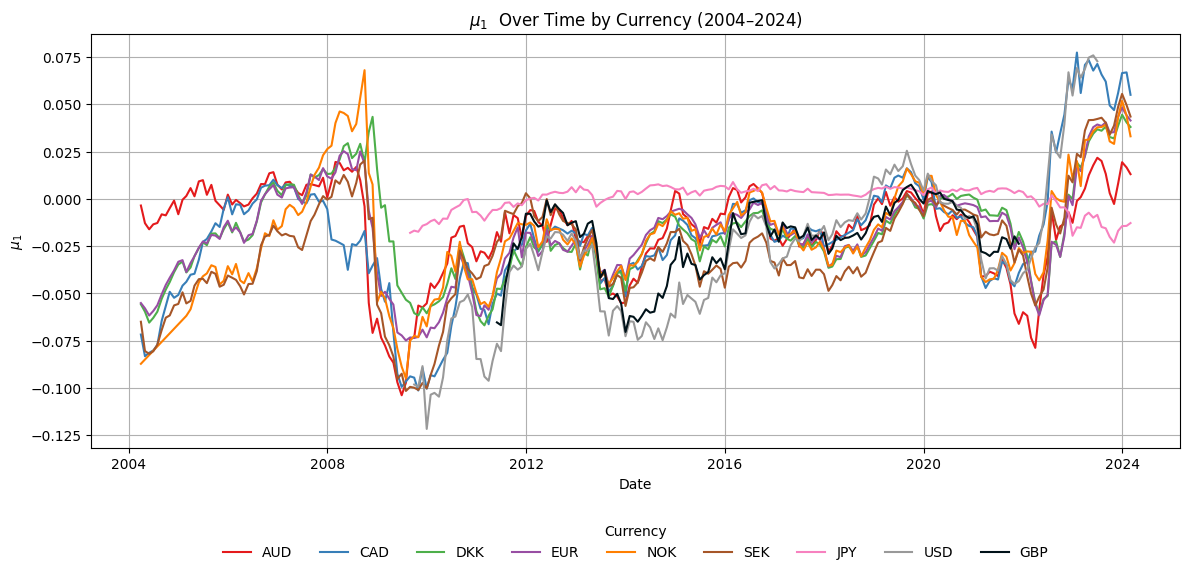

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

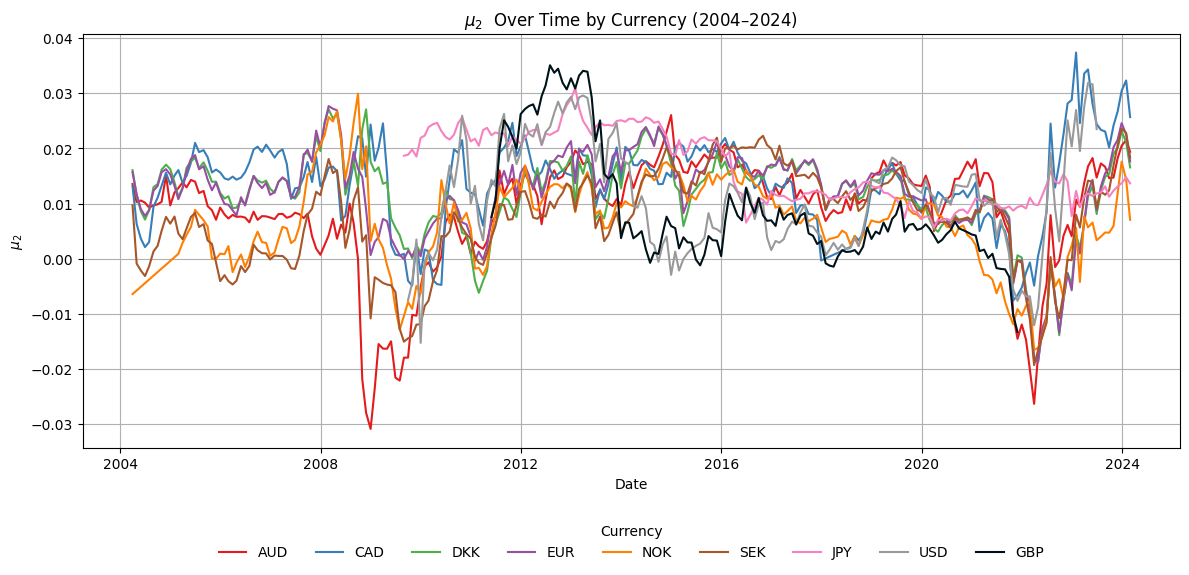

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

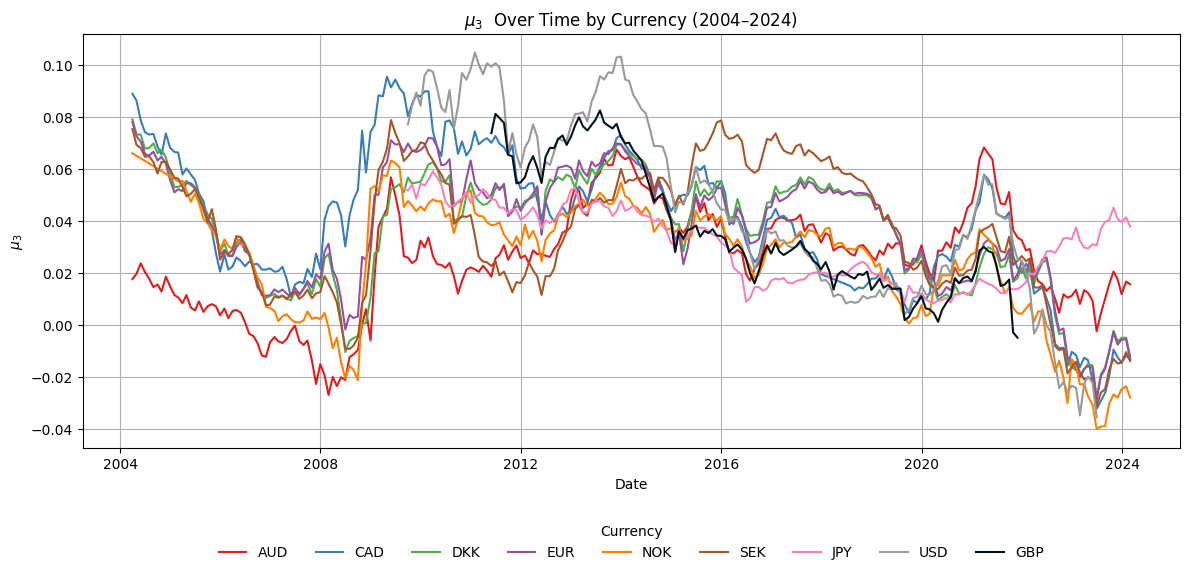

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 2].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_3$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

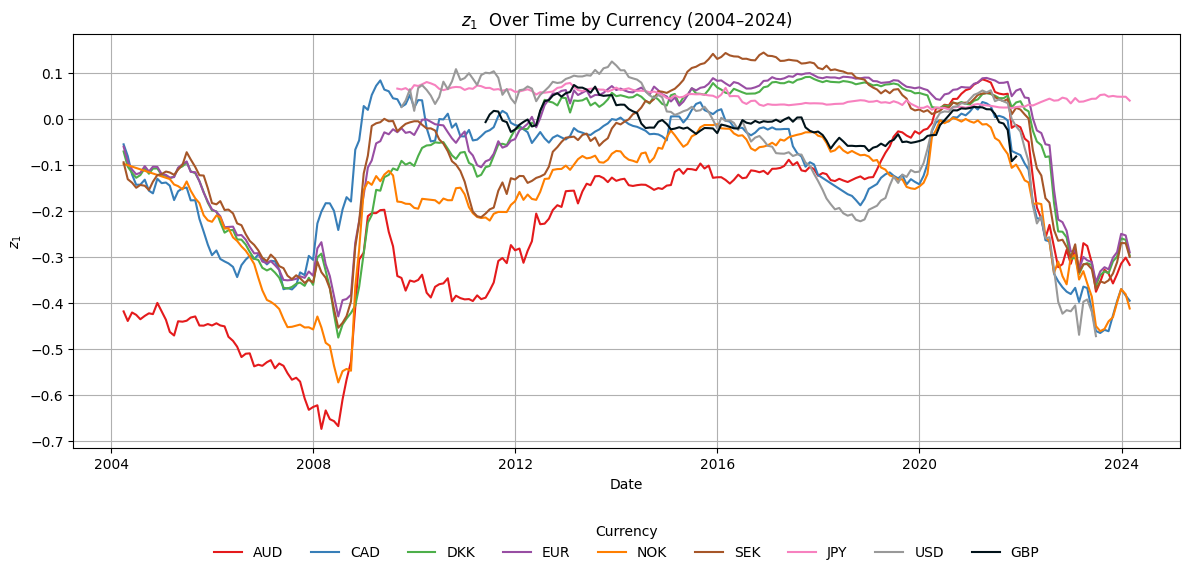

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

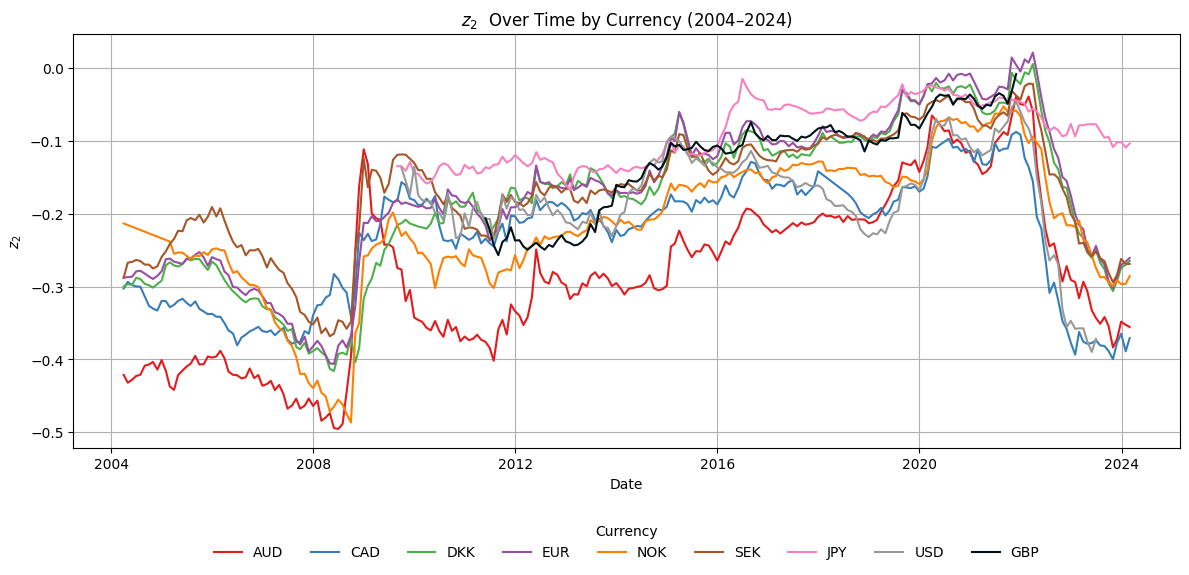

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

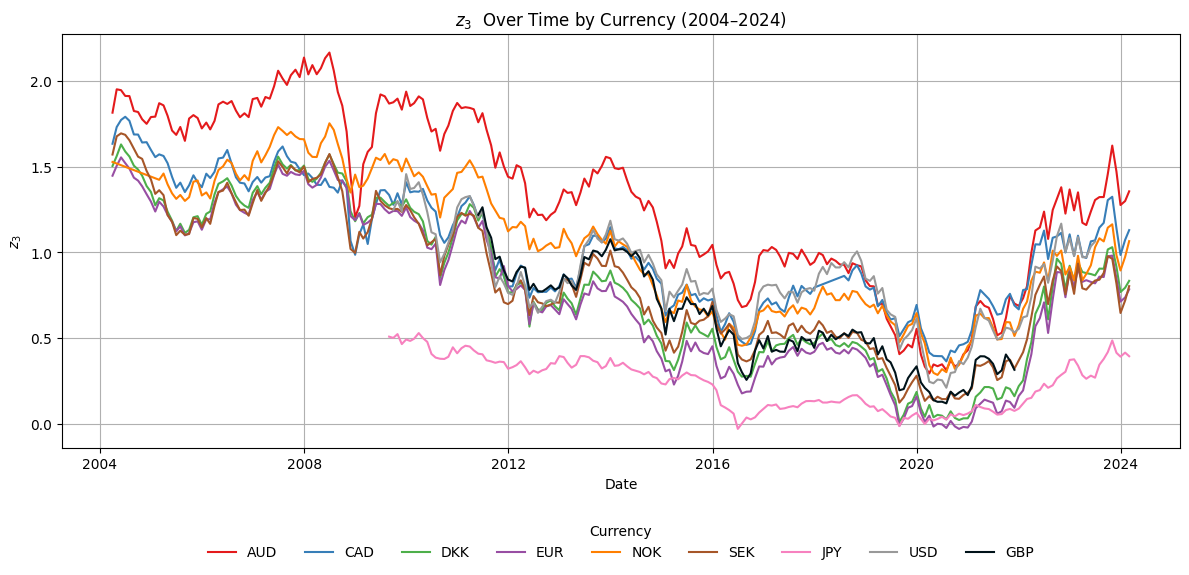

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 2].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_3$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()